In [1]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from dataset_path import output_path
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from keras.models import Sequential, Model,load_model
from keras.layers import Dense, Dropout, Activation, LSTM,  Input, concatenate
from keras.preprocessing import sequence
import tensorflow.keras.utils 
from tensorflow.keras import optimizers, metrics
from datetime import datetime
import os
from thesis_helper import * 
from imblearn.over_sampling import RandomOverSampler
import imblearn
pd.set_option('float_format', '{:.3f}'.format)
path = output_path

output_path = os.path.join(path, "Figure3")
if not os.path.exists(output_path):
    os.makedirs(output_path)
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed = 0
result_list = []

In [2]:
X_train,y_train,X_test,y_test = preprocessing(path,df_train,df_test)

Before filtering: training size = 334480 , testing size = 83620
After filtering: training size = 176213 , testing size = 44063


In [4]:
ros = RandomOverSampler(sampling_strategy='minority',random_state=8) # 6:6961
X_ros, y_ros = ros.fit_resample(X_train,y_train)

Dividing variable into groups

In [5]:
outcome = "outcome_ed_revisit_3d"

ed_variable = ["ed_temperature_last", "ed_heartrate_last", "ed_resprate_last", 
            "ed_o2sat_last", "ed_sbp_last", "ed_dbp_last", "ed_los", "n_med", "n_medrecon"]
#ed_triage table
eci_variable = ["eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",  
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss", 
            "eci_Anemia", "eci_Alcohol", "eci_Drugs", "eci_Psychoses", "eci_Depression"] 
#An Elixhauser comorbidity score of >15 can be used as a cut-off value with a 1-year mortality of 38%. 
# This cut-off value is based on the ROC curve and the clinical interpretation of a reasonable life expectancy. The score of >15 is the highest tertile.
# The high-risk patients with a score >15 should be considered carefully in the heart team, also with regards to other valve lesions and the clippability of the anatomy of the mitral valve. 
# The prognosis should also be discussed with the patient in order to achieve shared decision-making.

cci_variable = ["cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", "cci_Pulmonary", 
            "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", "cci_DM2", 
            "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", "cci_Cancer2", 
            "cci_HIV"] # Based on the CCI score, the severity of comorbidity was categorized into three grades: mild, with CCI scores of 1-2; moderate, with CCI scores of 3-4; and severe, with CCI scores ≥5.

chiefcom_variable = ["chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness"] #a concise statement describing the symptom, problem, condition, diagnosis, physician-recommended return, or other reason(true or false)

patient_variable = ["age", "gender"] #general information

n_variable = ["n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d"] #past_visit

triage_variable = ["triage_pain", "triage_acuity"]

variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", "cci_Pulmonary", 
            "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", "cci_DM2", 
            "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", "cci_Cancer2", 
            "cci_HIV",
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",  
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss", 
            "eci_Anemia", "eci_Alcohol", "eci_Drugs", "eci_Psychoses", "eci_Depression",
            
            "ed_temperature_last", "ed_heartrate_last", "ed_resprate_last", 
            "ed_o2sat_last", "ed_sbp_last", "ed_dbp_last", "ed_los", "n_med", "n_medrecon"]



ed_train = X_ros[ed_variable].copy()
eci_train = X_ros[eci_variable].copy()
cci_train = X_ros[cci_variable].copy()
chiefcom_train = X_ros[chiefcom_variable].copy()
patient_train = X_ros[patient_variable].copy()
n_train = X_ros[n_variable].copy()
triage_train = X_ros[triage_variable].copy()
y_train = y_ros

# X_train = df_train[variable].copy()
# ed_train = df_train[ed_variable].copy()
# eci_train = df_train[eci_variable].copy()
# cci_train = df_train[cci_variable].copy()
# chiefcom_train = df_train[chiefcom_variable].copy()
# patient_train = df_train[patient_variable].copy()
# n_train = df_train[n_variable].copy()
# triage_train = df_train[triage_variable].copy()
# y_train = df_train[outcome].copy()

ed_test = X_test[ed_variable].copy()
eci_test  = X_test[eci_variable].copy()
cci_test  = X_test[cci_variable].copy()
chiefcom_test  = X_test[chiefcom_variable].copy()
patient_test  = X_test[patient_variable].copy()
n_test  = X_test[n_variable].copy()
triage_test  = X_test[triage_variable].copy()

resample_freq = '1H' #'30T'
encoder = LabelEncoder()
patient_train['gender'] = encoder.fit_transform(patient_train['gender'])
patient_test['gender'] = encoder.transform(patient_test['gender'])
ed_train['ed_los'] = pd.to_timedelta(ed_train['ed_los']).dt.seconds / 60
ed_test['ed_los'] = pd.to_timedelta(ed_test['ed_los']).dt.seconds / 60

df_vitalsign = pd.read_csv(os.path.join(path, 'ed_vitalsign_' + resample_freq + '_resampled.csv'))

Multimodel lstm training and predicitng 

In [6]:
ed_input,ed_input1 = convert_data(ed_train,ed_test,ed_variable,df_vitalsign,ed = True)
eci_input,eci_input1 = convert_data(eci_train,eci_test,eci_variable,df_vitalsign)
cci_input,cci_input1 = convert_data(cci_train,cci_test,cci_variable,df_vitalsign)
chiefcom_input,chiefcom_input1 = convert_data(chiefcom_train,chiefcom_test,chiefcom_variable,df_vitalsign)
patient_input,patient_input1 = convert_data(patient_train,patient_test,patient_variable,df_vitalsign,patient = True)
n_input,n_input1 = convert_data(n_train,n_test,n_variable,df_vitalsign)
triage_input,triage_input1 = convert_data(triage_train,triage_test,triage_variable,df_vitalsign)

input_1  = Input(shape=(ed_input.shape[1], ed_input.shape[2]),  name='input_1')
input_2  = Input(shape=(eci_input.shape[1], eci_input.shape[2]),  name='input_2')
input_3  = Input(shape=(cci_input.shape[1], cci_input.shape[2]),  name='input_3')
input_4  = Input(shape=(chiefcom_input.shape[1], chiefcom_input.shape[2]),  name='input_4')
input_5  = Input(shape=(patient_input.shape[1], patient_input.shape[2]),  name='input_5')
input_6  = Input(shape=(n_input.shape[1], n_input.shape[2]),  name='input_6')
input_7  = Input(shape=(triage_input.shape[1], triage_input.shape[2]),  name='input_7')

# lstms
lstm1  = LSTM(5, name='lstm1')(input_1) # 5
lstm2  = LSTM(9, name='lstm2')(input_2) # 9
lstm3  = LSTM(8, name='lstm3')(input_3) # 8
lstm4  = LSTM(5, name='lstm4')(input_4) # 5
lstm5  = LSTM(2, name='lstm5')(input_5) # 2
lstm6  = LSTM(4, name='lstm6')(input_6) # 4
lstm7  = LSTM(4, name='lstm7')(input_7) # 4

# outputs
# output1  = Dense(5, activation="relu", name='out1')(lstm1)
# output2  = Dense(9, activation="relu", name='out2')(lstm2)
# output3  = Dense(18, activation="relu", name='out3')(lstm3)
# output4  = Dense(5, activation="relu", name='out4')(lstm4)
# output5  = Dense(1, activation="relu", name='out5')(lstm5)
# output6  = Dense(4, activation="relu", name='out6')(lstm6)
# output7  = Dense(1, activation="relu", name='out7')(lstm7)

# output2_1  = Dense(1, activation="relu", name='out21')(lstm1)
# output2_2  = Dense(1, activation="relu", name='out22')(lstm2)
# output2_3  = Dense(1, activation="relu", name='out23')(lstm3)
# output2_4  = Dense(1, activation="relu", name='out24')(lstm4)
# output2_5  = Dense(1, activation="relu", name='out25')(lstm5)
# output2_6  = Dense(1, activation="relu", name='out26')(lstm6)
# output2_7  = Dense(1, activation="relu", name='out27')(lstm7)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=30)
    ,
]
epoch_num = 200

Epoch 1/200
1679/1679 [==============================] - 24s 9ms/step - loss: 0.6417 - accuracy: 0.6270 - true_positives: 80306.0000 - true_negatives: 130128.0000 - precision: 0.6806 - recall: 0.4786 - val_loss: 0.6271 - val_accuracy: 0.7819 - val_true_positives: 1008.0000 - val_true_negatives: 33446.0000 - val_precision: 0.1063 - val_recall: 0.4701
Epoch 2/200
1679/1679 [==============================] - 14s 8ms/step - loss: 0.6344 - accuracy: 0.6325 - true_positives: 82808.0000 - true_negatives: 129456.0000 - precision: 0.6835 - recall: 0.4935 - val_loss: 0.5876 - val_accuracy: 0.8107 - val_true_positives: 934.0000 - val_true_negatives: 34787.0000 - val_precision: 0.1158 - val_recall: 0.4356
Epoch 3/200
1679/1679 [==============================] - 14s 8ms/step - loss: 0.6327 - accuracy: 0.6343 - true_positives: 84635.0000 - true_negatives: 128249.0000 - precision: 0.6815 - recall: 0.5044 - val_loss: 0.6071 - val_accuracy: 0.7760 - val_true_positives: 1040.0000 - val_true_negatives: 3

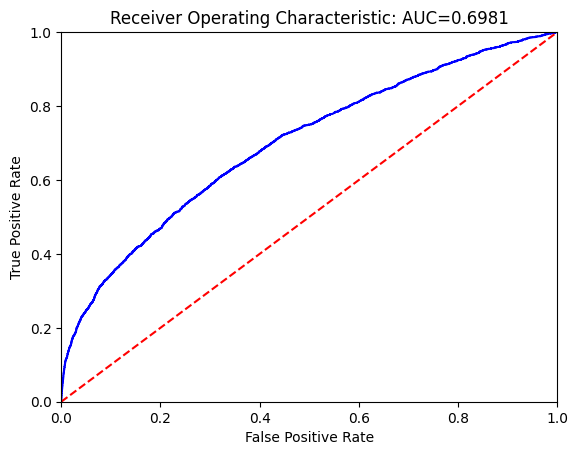

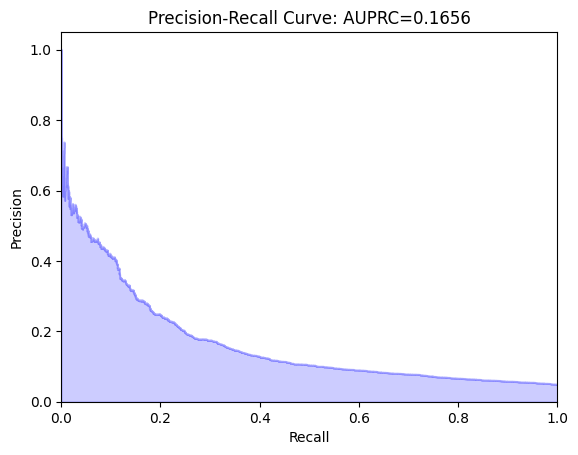

In [7]:
concat = concatenate([lstm1, lstm2,lstm3,lstm4,lstm5,lstm6,lstm7])
# concat = concatenate([output1,output2,output3,output4,output5,output6,output7])
# concat = concatenate([output2_1,output2_2,output2_3,output2_4,output2_5,output2_6,output2_7])
output_dropout = Dropout(0.3)(concat) 

#randomly sets input units to 0 with a frequency of rate at each step during training time, 
# which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.
output2 = Dense(1, activation="sigmoid", name='out2f')(output_dropout)

model = Model(inputs=[input_1, input_2,input_3,input_4,input_5,input_6,input_7], outputs=output2)

# model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics = ['accuracy',  
#                          'MAE','AUC'])

# a hyper-parameter used to govern the pace at which an algorithm updates or learns the values of a parameter estimate.
# Tthe learning rate regulates the weights of our neural network concerning the loss gradient>.
# model.compile(loss='binary_crossentropy', 
#               optimizer=optimizers.Adam(learning_rate=0.001),
#               metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
#                        'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
# model.compile(loss='binary_crossentropy', 
#               optimizer=optimizers.Adam(learning_rate=0.001),
#               metrics=['accuracy',{'auprc': metrics.AUC(name='auprc', curve='PR')}, 
#                        'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy', 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
history = model.fit([ed_input,eci_input,cci_input,chiefcom_input,patient_input,n_input,triage_input],y_train,epochs =200, batch_size = 200,callbacks=my_callbacks,
                    validation_data=([ed_input1,eci_input1,cci_input1,chiefcom_input1,patient_input1,n_input1,triage_input1], y_test))
runtime = time.time() - start
probs = model.predict([ed_input1,eci_input1,cci_input1,chiefcom_input1,patient_input1,n_input1,triage_input1])
# result_multilstm = PlotROCCurve_multilstm(path,probs, y_test, ci=confidence_interval, random_seed=random_seed)
result_multilstm = PlotROCCurve(probs, y_test, ci=confidence_interval, random_seed=random_seed)

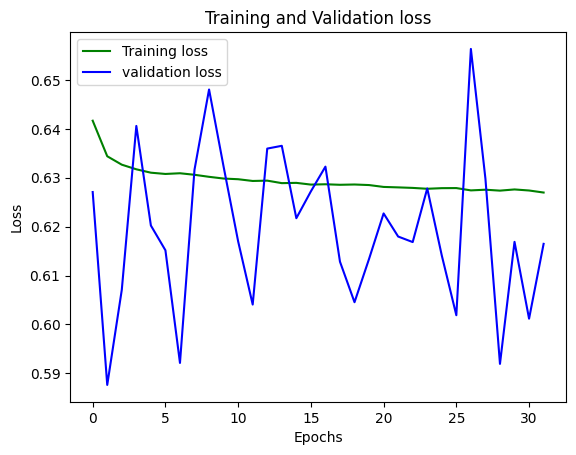

INFO:tensorflow:Assets written to: results/2023-10-22-log (3)/72h_ed_revisit_multimodel_lstm\assets


INFO:tensorflow:Assets written to: results/2023-10-22-log (3)/72h_ed_revisit_multimodel_lstm\assets


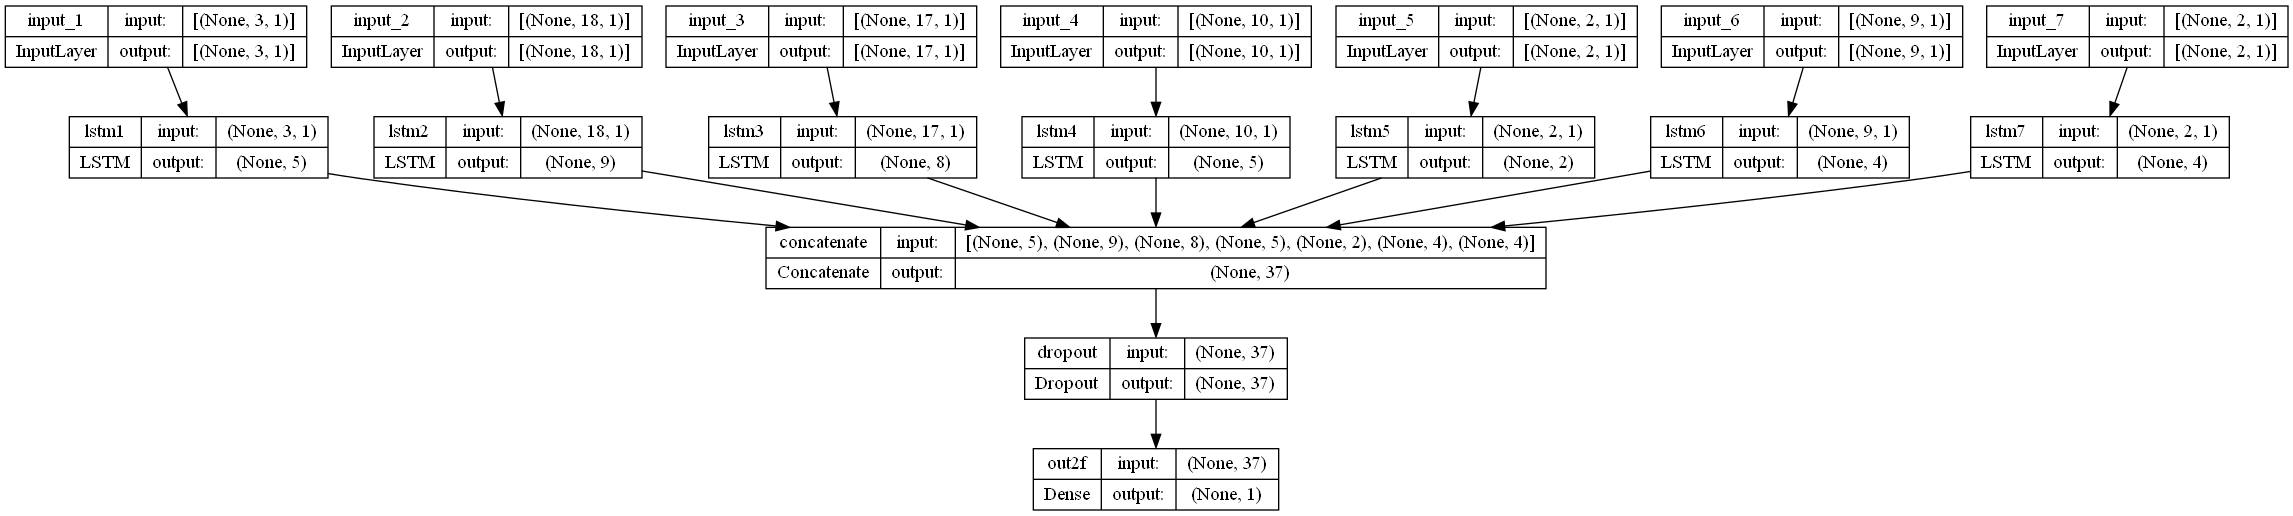

In [8]:
import matplotlib.pyplot as plt
def uniquify(path):
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = filename + " (" + str(counter) + ")" + extension
        counter += 1

    return path

today = datetime.now()

if today.hour < 12:
    h = "00"
else:
    h = "12"

path = 'results/' + today.strftime("%Y-%m-%d") +'-log'
path = uniquify(path)
os.makedirs(path)
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(len(history.history['loss']))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(path+'/train_loss.png')
plt.show()

model.save(path + '/72h_ed_revisit_multimodel_lstm')
import pickle

with open('trainHistoryOld', 'wb') as handle: # saving the history of the model
    pickle.dump(history.history, handle)

hist_df = pd.DataFrame(history.history) 


# or save to csv: 
hist_csv_file = path +'/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

tensorflow.keras.utils.plot_model(model, path + '/model_architecture.png', show_shapes=True)

C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 167809, number of negative: 167809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 335618, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0:	learn: 0.6503182	total: 25.9ms	remaining: 1.53s
1:	learn: 0.6421160	total: 48.7ms	remaining: 1.41s
2:	learn: 0.6384222	total: 73.2ms	remaining: 1.39s
3:	learn: 0.6353635	total: 96.2ms	remaining: 1.35s
4:	learn: 0.6330204	total: 119ms	remaining: 1.3s
5:	learn: 0.6314180	total: 142ms	remaining: 1.28s
6:	learn: 0.6303428	total: 165ms	remaining: 1.25s
7:	learn: 0.6295747	total: 190ms	remaining: 1.23s
8:	learn: 0.6284823	total: 214ms	remaining: 1.21s
9:	learn: 0.6279080	total: 237ms	remainin

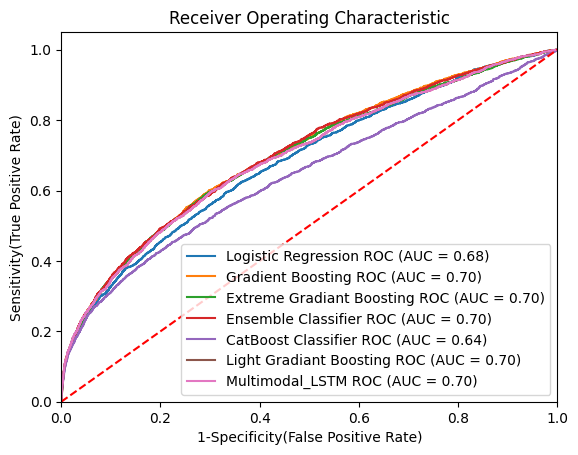

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import lightgbm as lgb
from catboost import CatBoostRegressor,CatBoostClassifier
from xgboost import XGBClassifier
plt.figure()
clf1 = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=45)
clf2 = CatBoostClassifier(iterations=60,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass',random_state=45)
clf3 = XGBClassifier(base_score=0.5, booster='gbtree',colsample_bylevel=1,
       colsample_bynode=1,colsample_bytree=1, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=3, min_child_weight=1,n_estimators=250, n_jobs=20, nthread=None,
        random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)


eclf = VotingClassifier(estimators=[('LGB', clf1), ('CatB', clf2), ('XGB', clf3)],voting='soft',weights = [1,1,1])
# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(random_state=random_seed),
},
{
    'label': 'Extreme Gradiant Boosting',
    'model': XGBClassifier(base_score=0.5, booster='gbtree',colsample_bylevel=1,
       colsample_bynode=1,colsample_bytree=1, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=3, min_child_weight=1,n_estimators=250, n_jobs=20, nthread=None,
        random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
},
{
    'label': 'Ensemble Classifier',
    'model': eclf,
},
{
    'label': 'CatBoost Classifier',
    'model': CatBoostClassifier(random_state=random_seed),
},
{
    'label': 'Light Gradiant Boosting',
    'model': lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=random_seed),
},
{
    'label': 'Multimodal_LSTM',
    'model': model,
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    # if m['label'] == 'CatBoost Classifier':
    #     arr = []
    #     for x in yp:
    #         if x == 'True':
    #             arr.append(True)
    #         else:
    #             arr.append(False)
    #     y_t = y_test.to_numpy()
    if m['label'] != 'Multimodal_LSTM':
        model.fit(X_ros, y_ros) # train the model
        y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    #auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label='%s ROC (AUC = %0.2f)' % (m['label'], roc_auc))
    else:
        plt.plot(fpr, tpr, label='%s ROC (AUC = %0.2f)' % (m['label'], 0.6981))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

1377/1377 [==============================] - 4s 2ms/step
AUC: 0.695203656358585
AUPRC: 0.1675656701440447
Sensitivity: 0.6380597014925373
Specificity: 0.642858846823636
Score thresold: 0.039245795
2.5 97.5


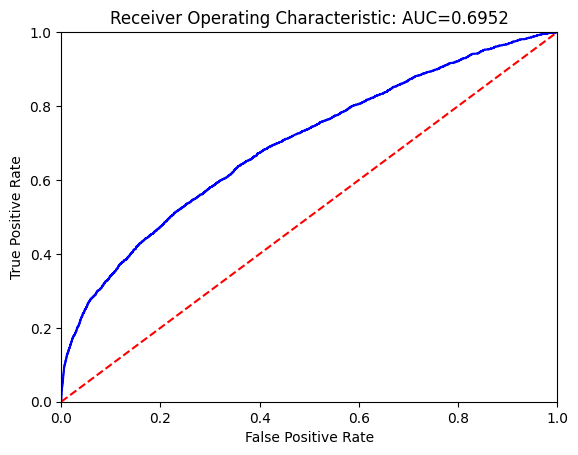

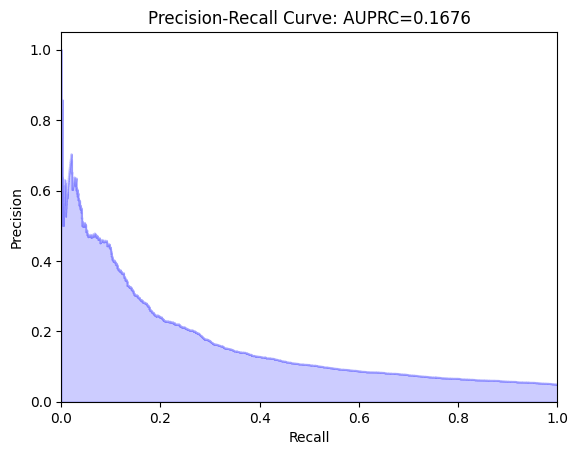

NameError: name 'csv' is not defined

In [22]:
lstm = load_model(path +'/72h_ed_revisit_multimodel_lstm')
probs = lstm.predict([ed_input1,eci_input1,cci_input1,chiefcom_input1,patient_input1,n_input1,triage_input1])
# result_multilstm = PlotROCCurve_multilstm(path,probs, y_test, ci=confidence_interval, random_seed=random_seed)
result_multilstm = PlotROCCurve(probs, y_test, ci=confidence_interval, random_seed=random_seed)
new_probs = []
i = 0
for x in probs:
    if x[0] < float(result_multilstm[4]):
        new_probs.append(False)
    else:
        new_probs.append(True)


acc = metrics.accuracy_score(y_test, new_probs)
result_multilstm.append(acc)
with open(path +'/result.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    
    header = ['roc_auc', 'average_precision', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity','accuracy_score']
    writer.writerow(header)
    
    result = [str(a) for a in result_multilstm]
    print(result_multilstm)
    writer.writerow(result_multilstm)
    
    file.close()
results = ["Multimodel-LSTM"]
results.extend(result_multilstm)
results.append(runtime)
result_list.append(results)

Confusion matrix for training set and testing set

In [ ]:
cm1 = metrics.confusion_matrix(y_test,new_probs)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = [False, True])

cm_display.plot()
plt.savefig(path + '/confusion_matrix.png')
plt.show()

176213

5507/5507 [==============================] - 10s 2ms/step


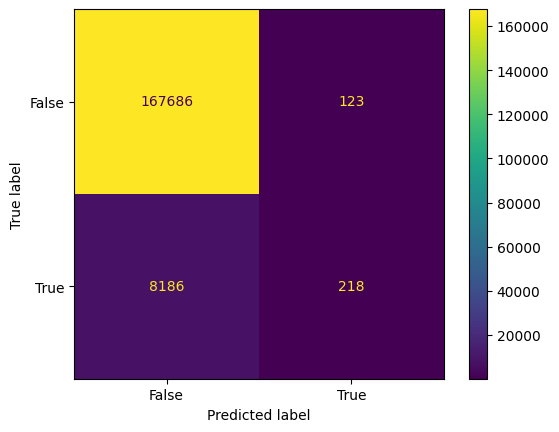

In [24]:
train_probs = model.predict([ed_input,eci_input,cci_input,chiefcom_input,patient_input,n_input,triage_input])
#train_result_multilstm = PlotROCCurve_multilstm(path,train_probs, y_train, ci=confidence_interval, random_seed=random_seed)
train_new_probs = []

i = 0
for x in train_probs:
    if x[0] < 0.5:
        train_new_probs.append(False)
    else:
        train_new_probs.append(True)



train_cm1 = metrics.confusion_matrix(y_train,train_new_probs)

train_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = train_cm1, display_labels = [False, True])
train_cm_display.plot()
misclassified_tf = y_train[y_train!=train_new_probs]
misclassified_new_tf = []
for x in misclassified_tf:
    if x == True:
        misclassified_new_tf.append("True")
    elif x == False:
        misclassified_new_tf.append("False")


correct_tf = y_train[y_train==train_new_probs]
correct_new_tf = []
for x in correct_tf:
    if x == True:
        correct_new_tf.append("True")
    elif x == False:
        correct_new_tf.append("False")

In [13]:
probs = model.predict([ed_input1,eci_input1,cci_input1,chiefcom_input1,patient_input1,n_input1,triage_input1])
#train_result_multilstm = PlotROCCurve_multilstm(path,train_probs, y_train, ci=confidence_interval, random_seed=random_seed)
test_new_probs = []

i = 0
for x in probs:
    if x[0] < 0.5:
        test_new_probs.append(False)
    else:
        test_new_probs.append(True)


   1/1377 [..............................] - ETA: 38s

1377/1377 [==============================] - 3s 2ms/step


In [14]:
cm1 = confusion_matrix(y_test,test_new_probs)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])

f = f1_score(y_test,test_new_probs)

print(f, accuracy1, sensitivity1, specificity1)

0.16746871992300288 0.7447972221591812 0.7559102077816742 0.527518656716418


In [13]:
probs

array([[0.0325602 ],
       [0.03918343],
       [0.02775804],
       ...,
       [0.03169481],
       [0.0603889 ],
       [0.03369687]], dtype=float32)

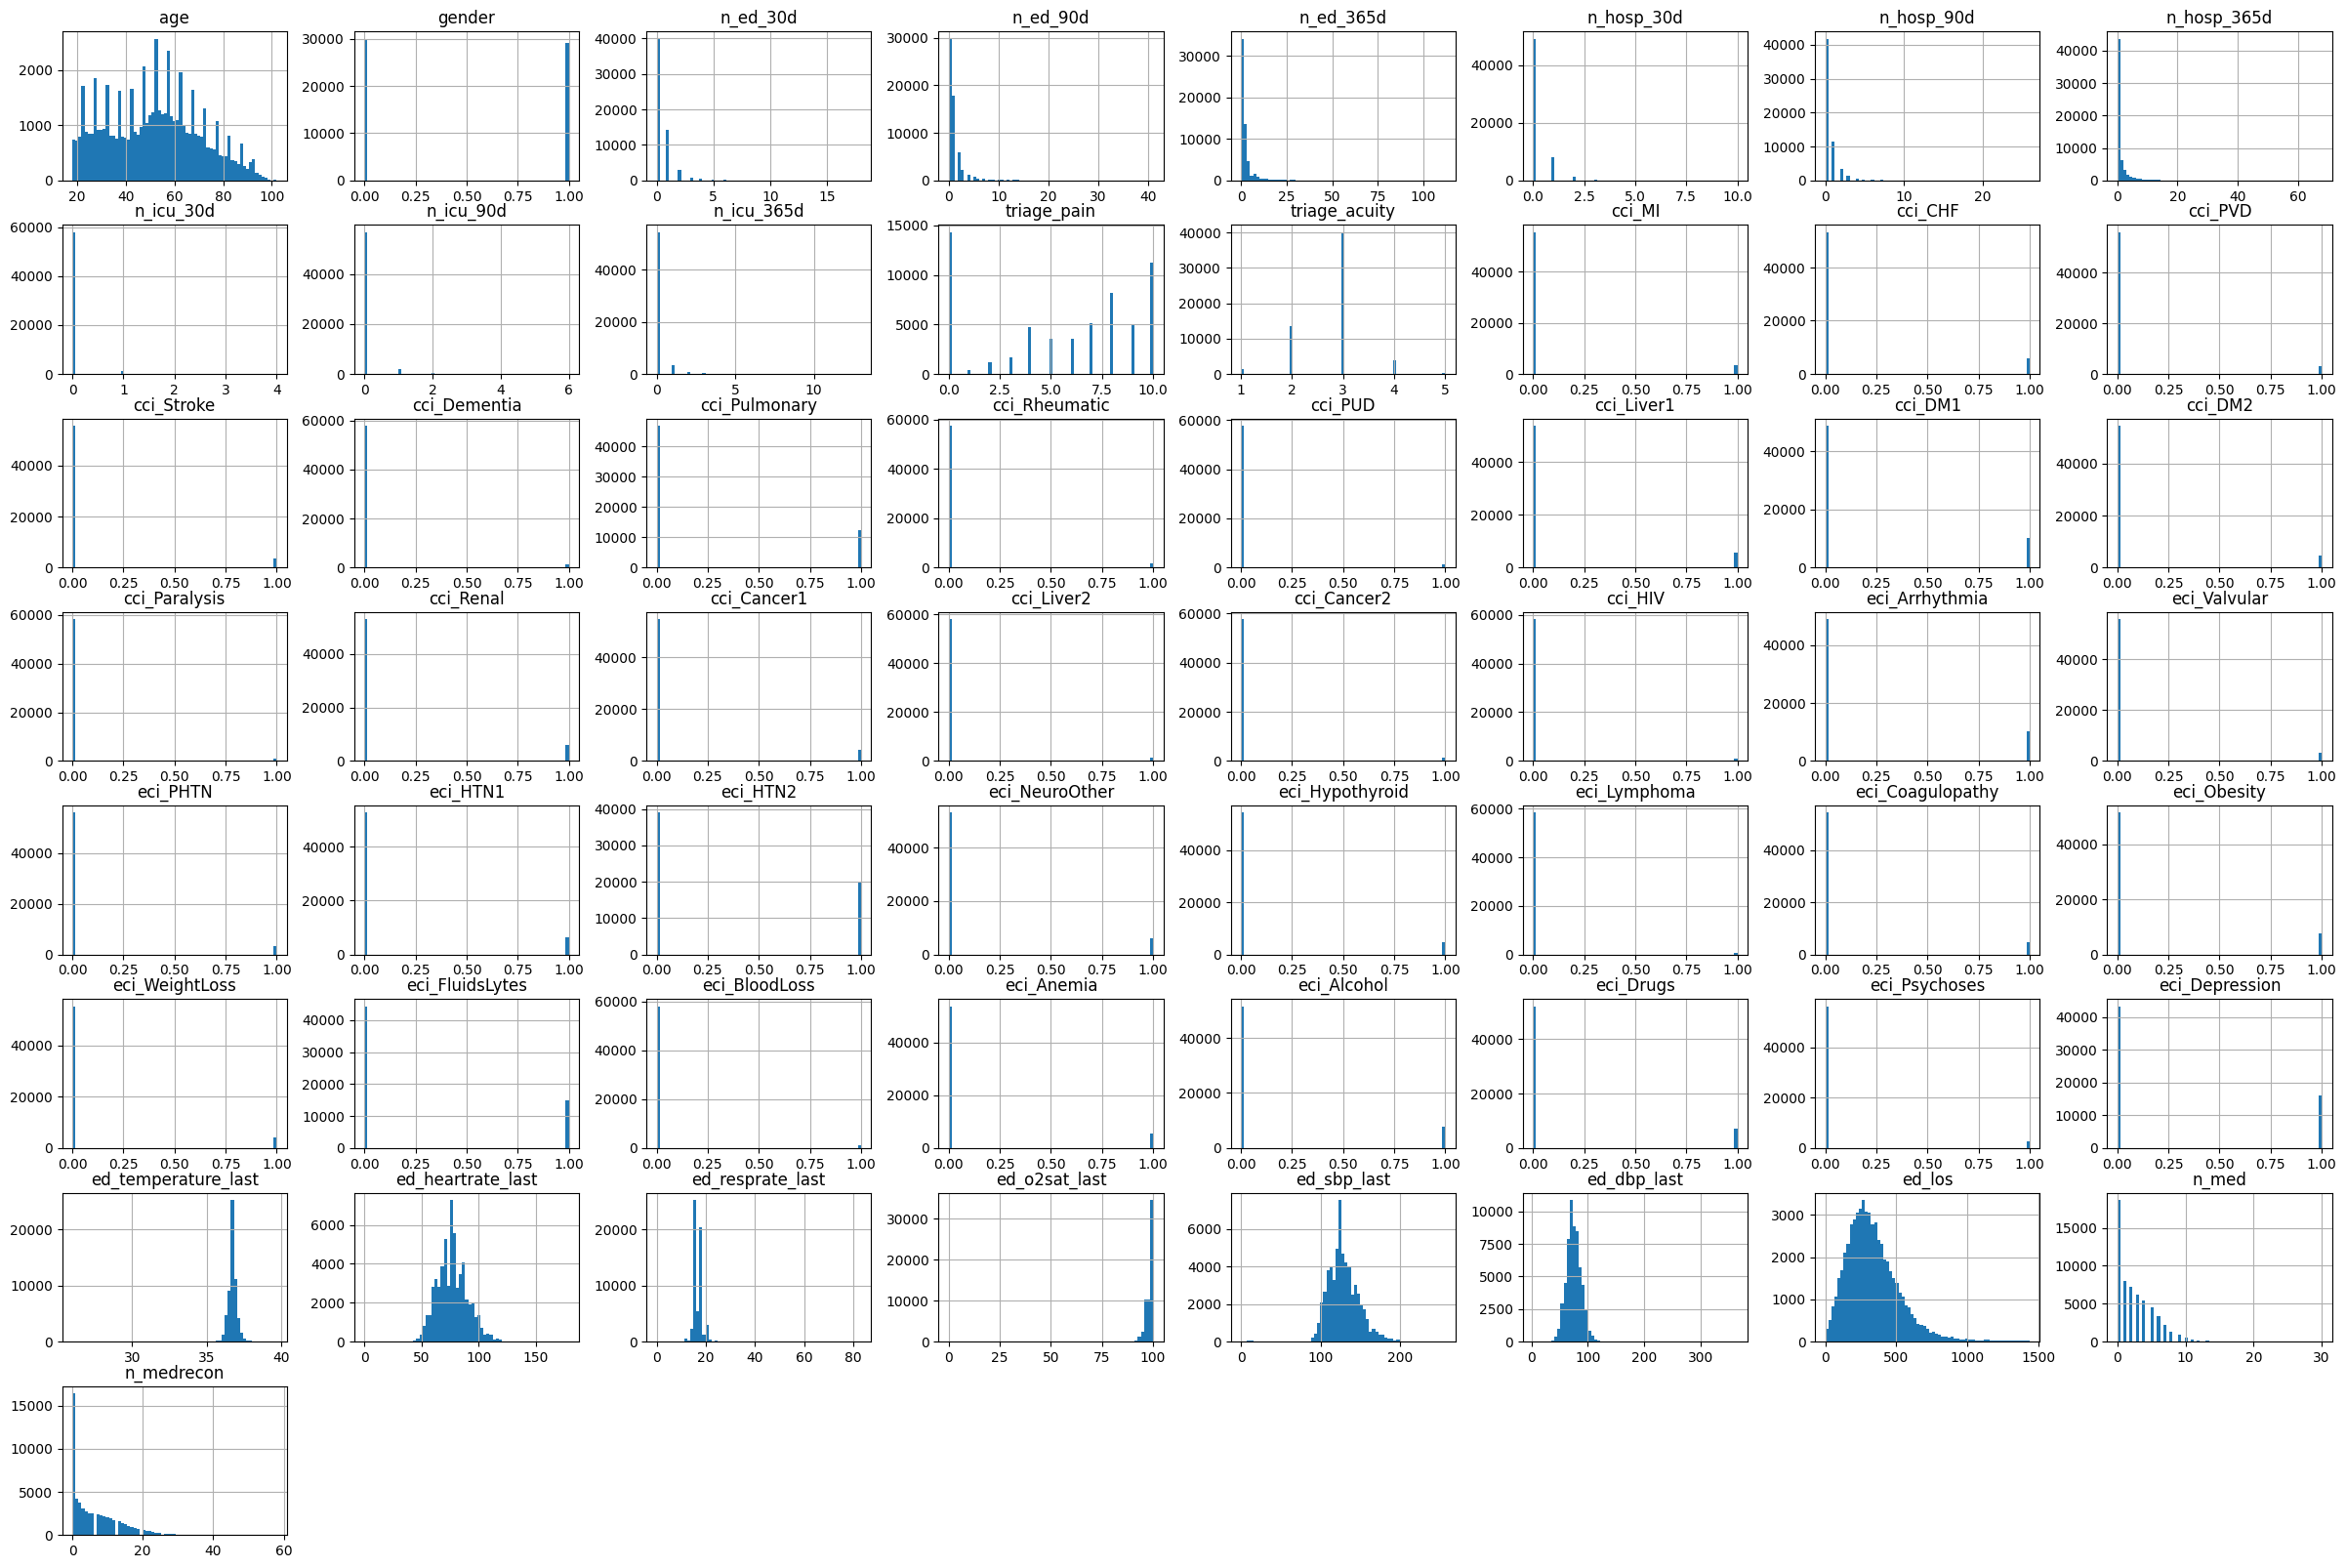

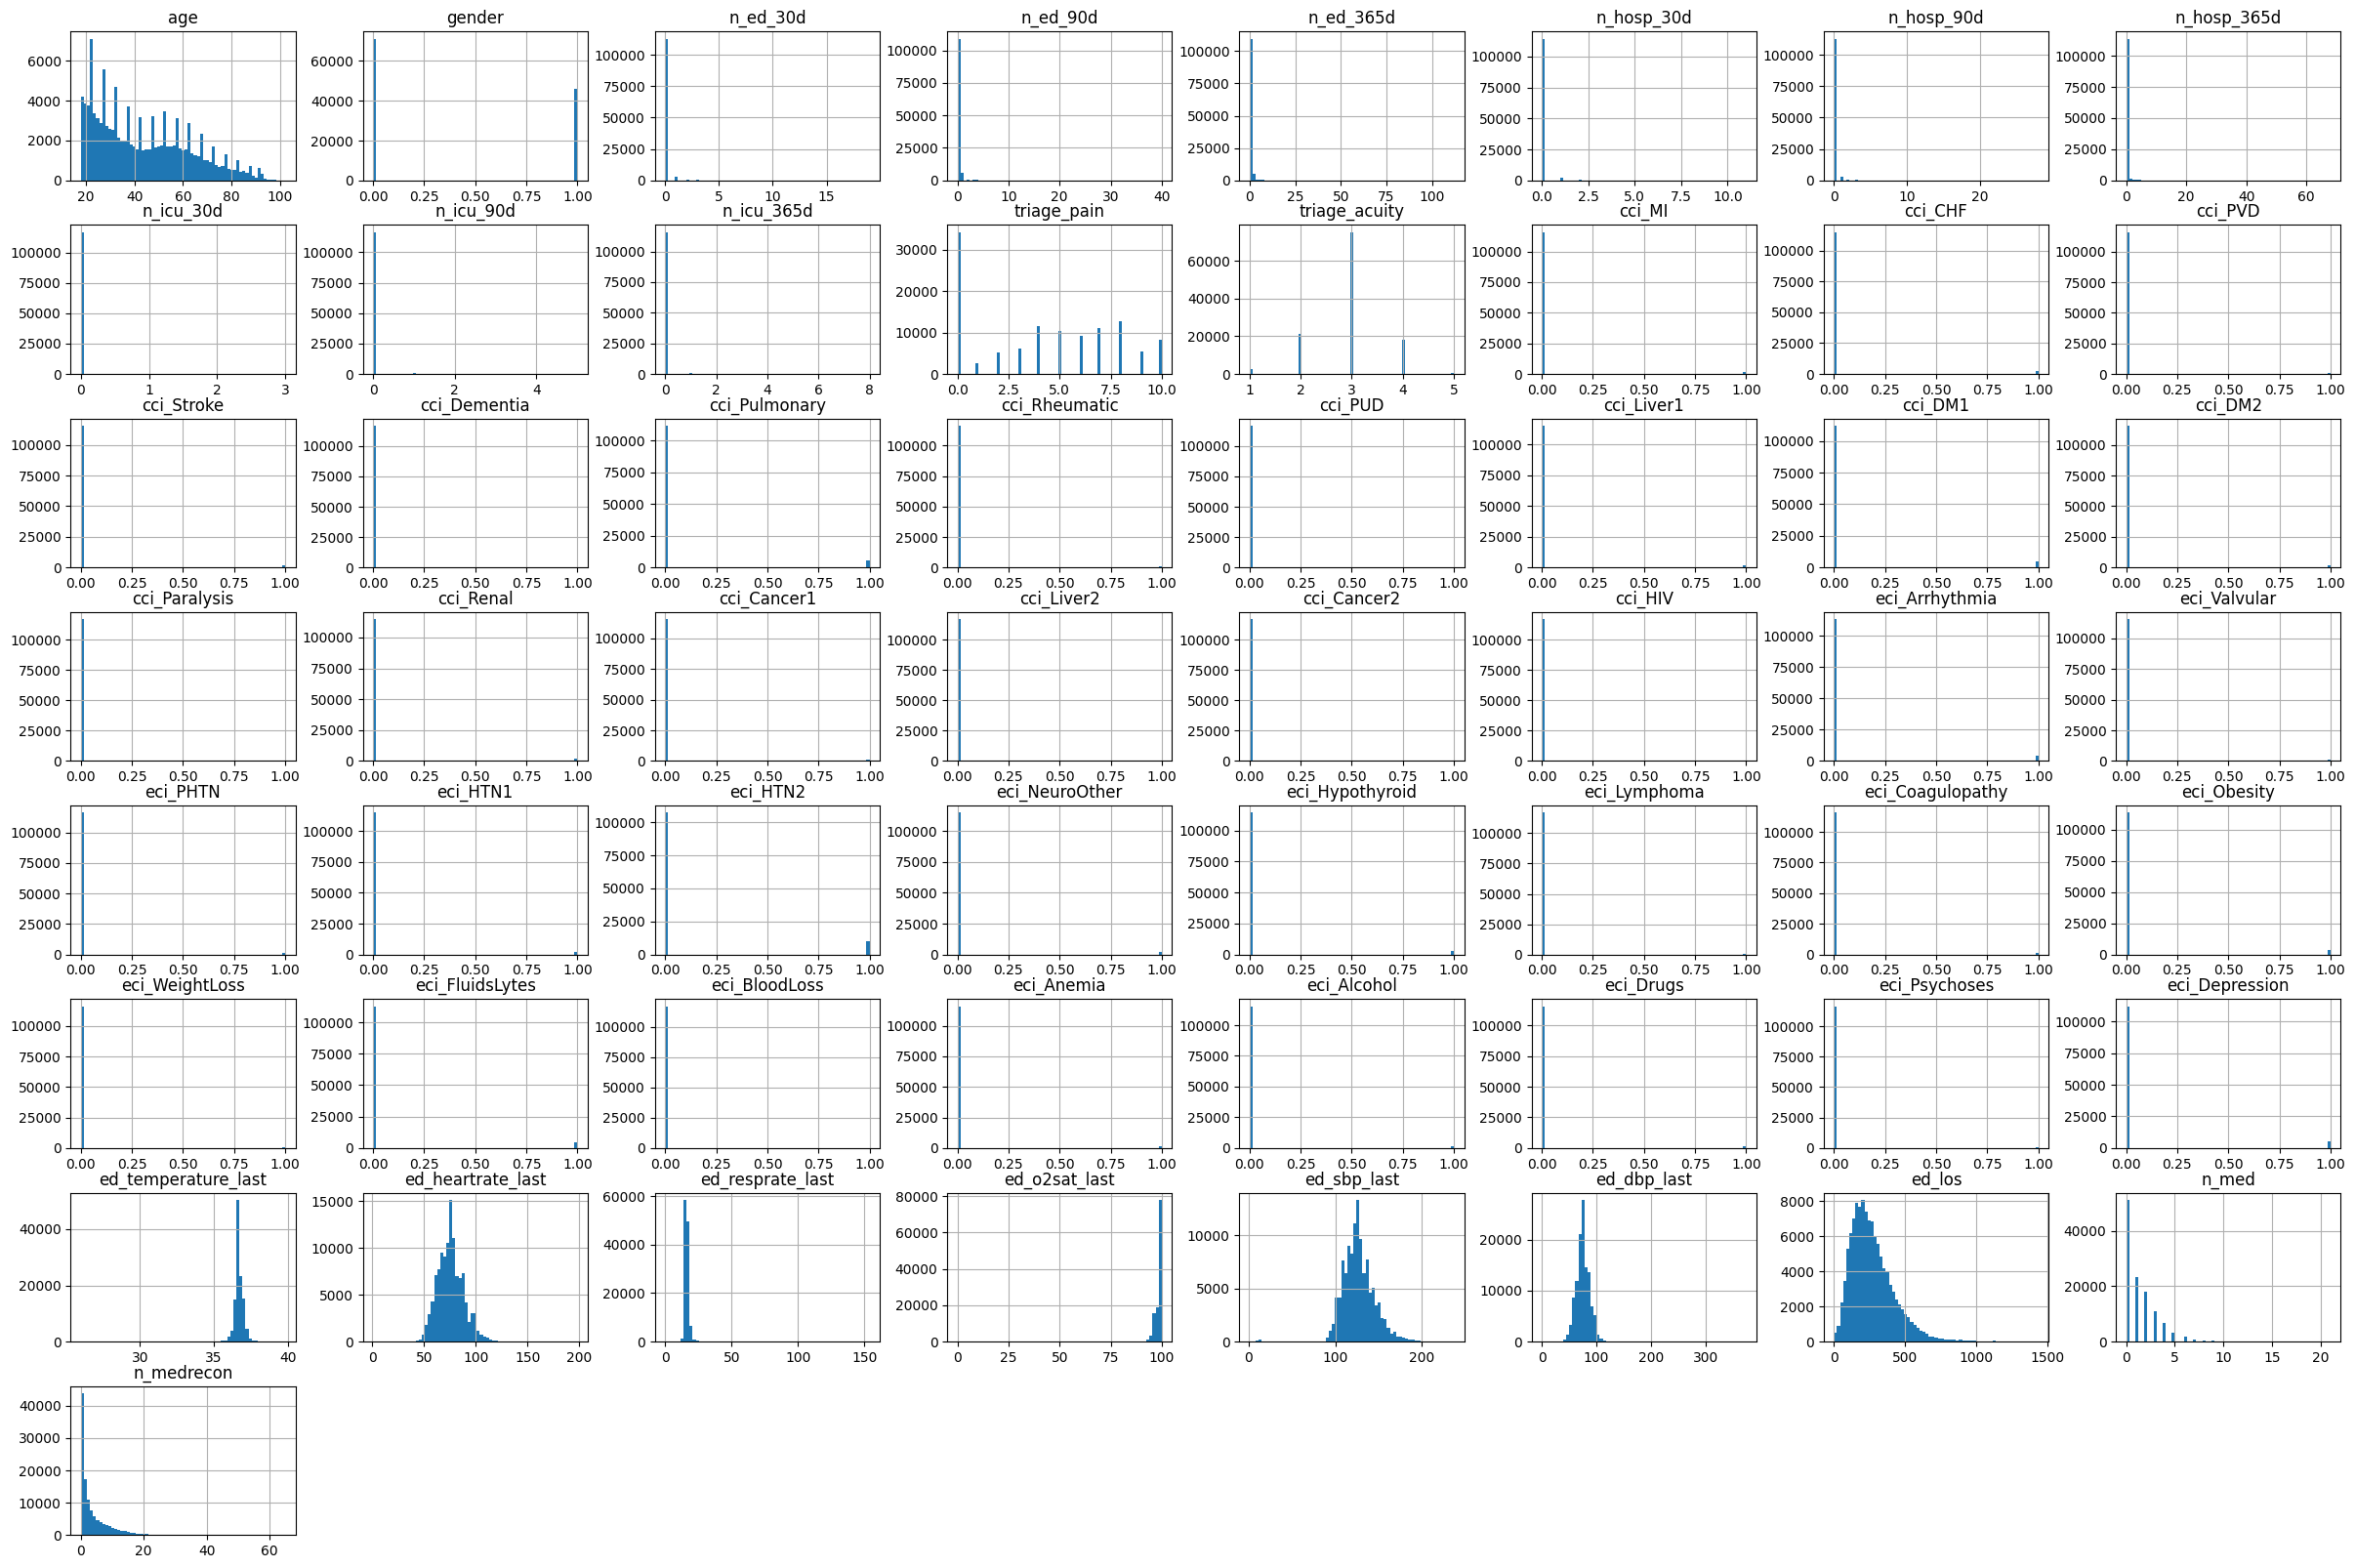

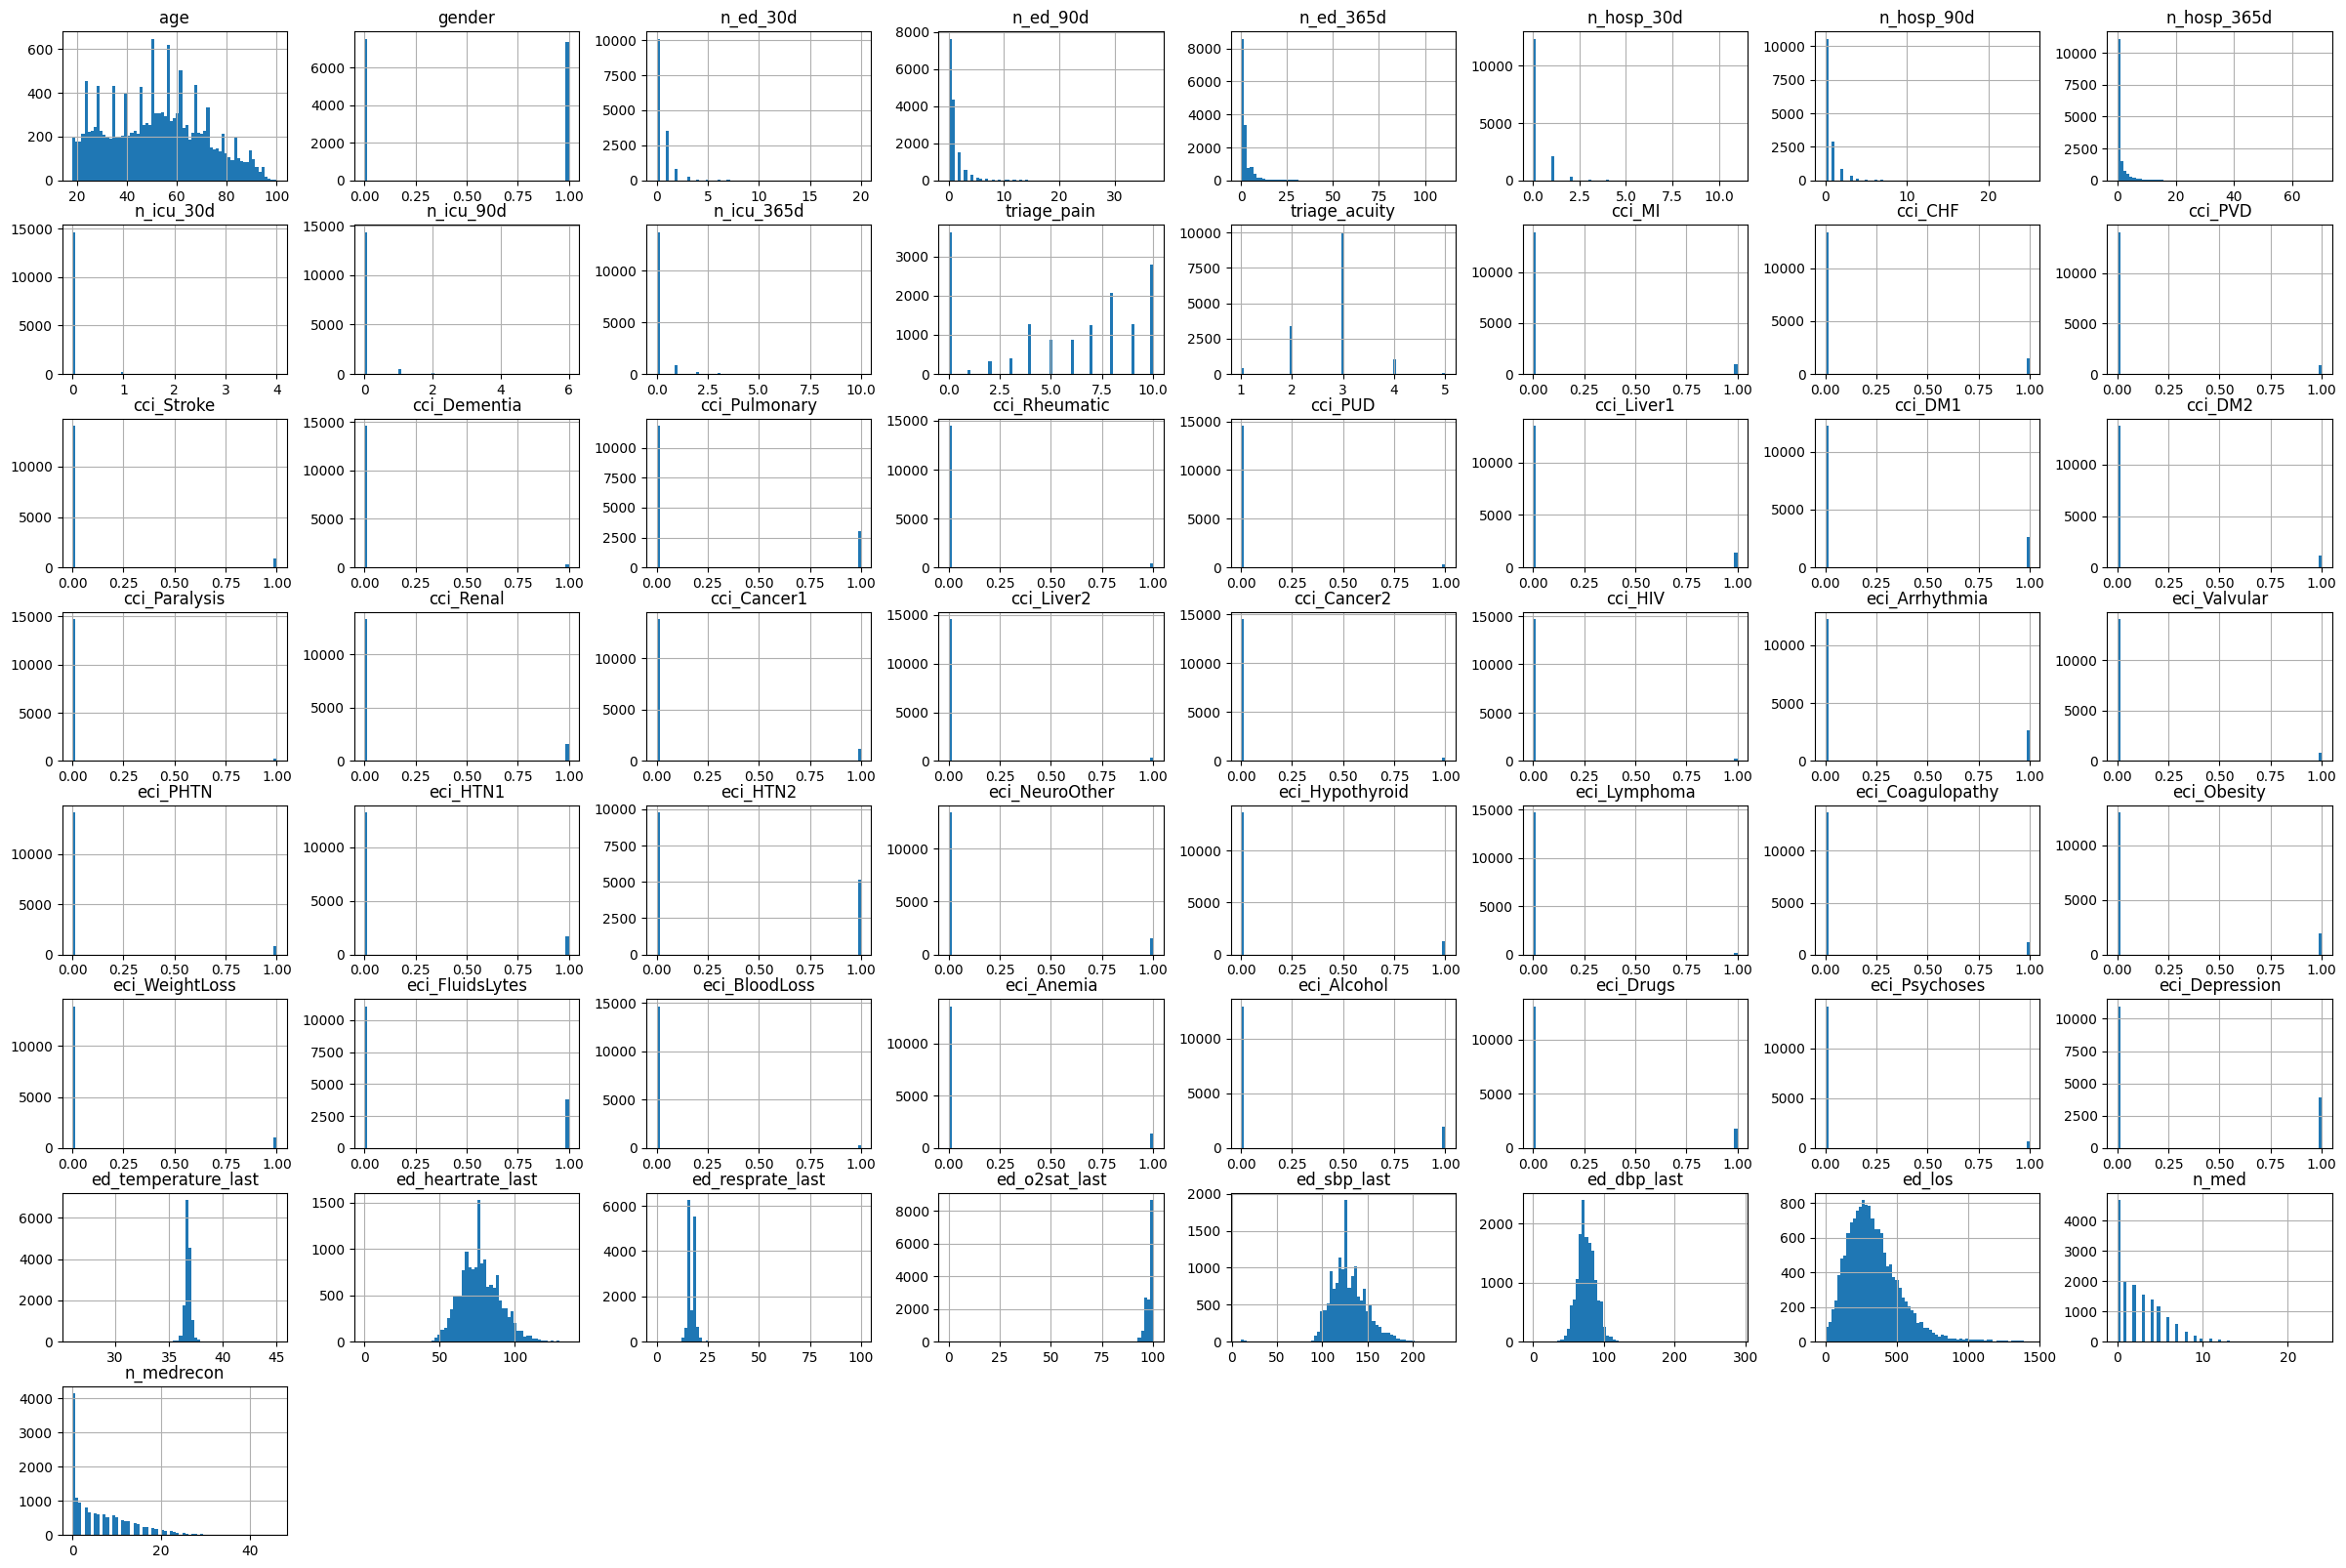

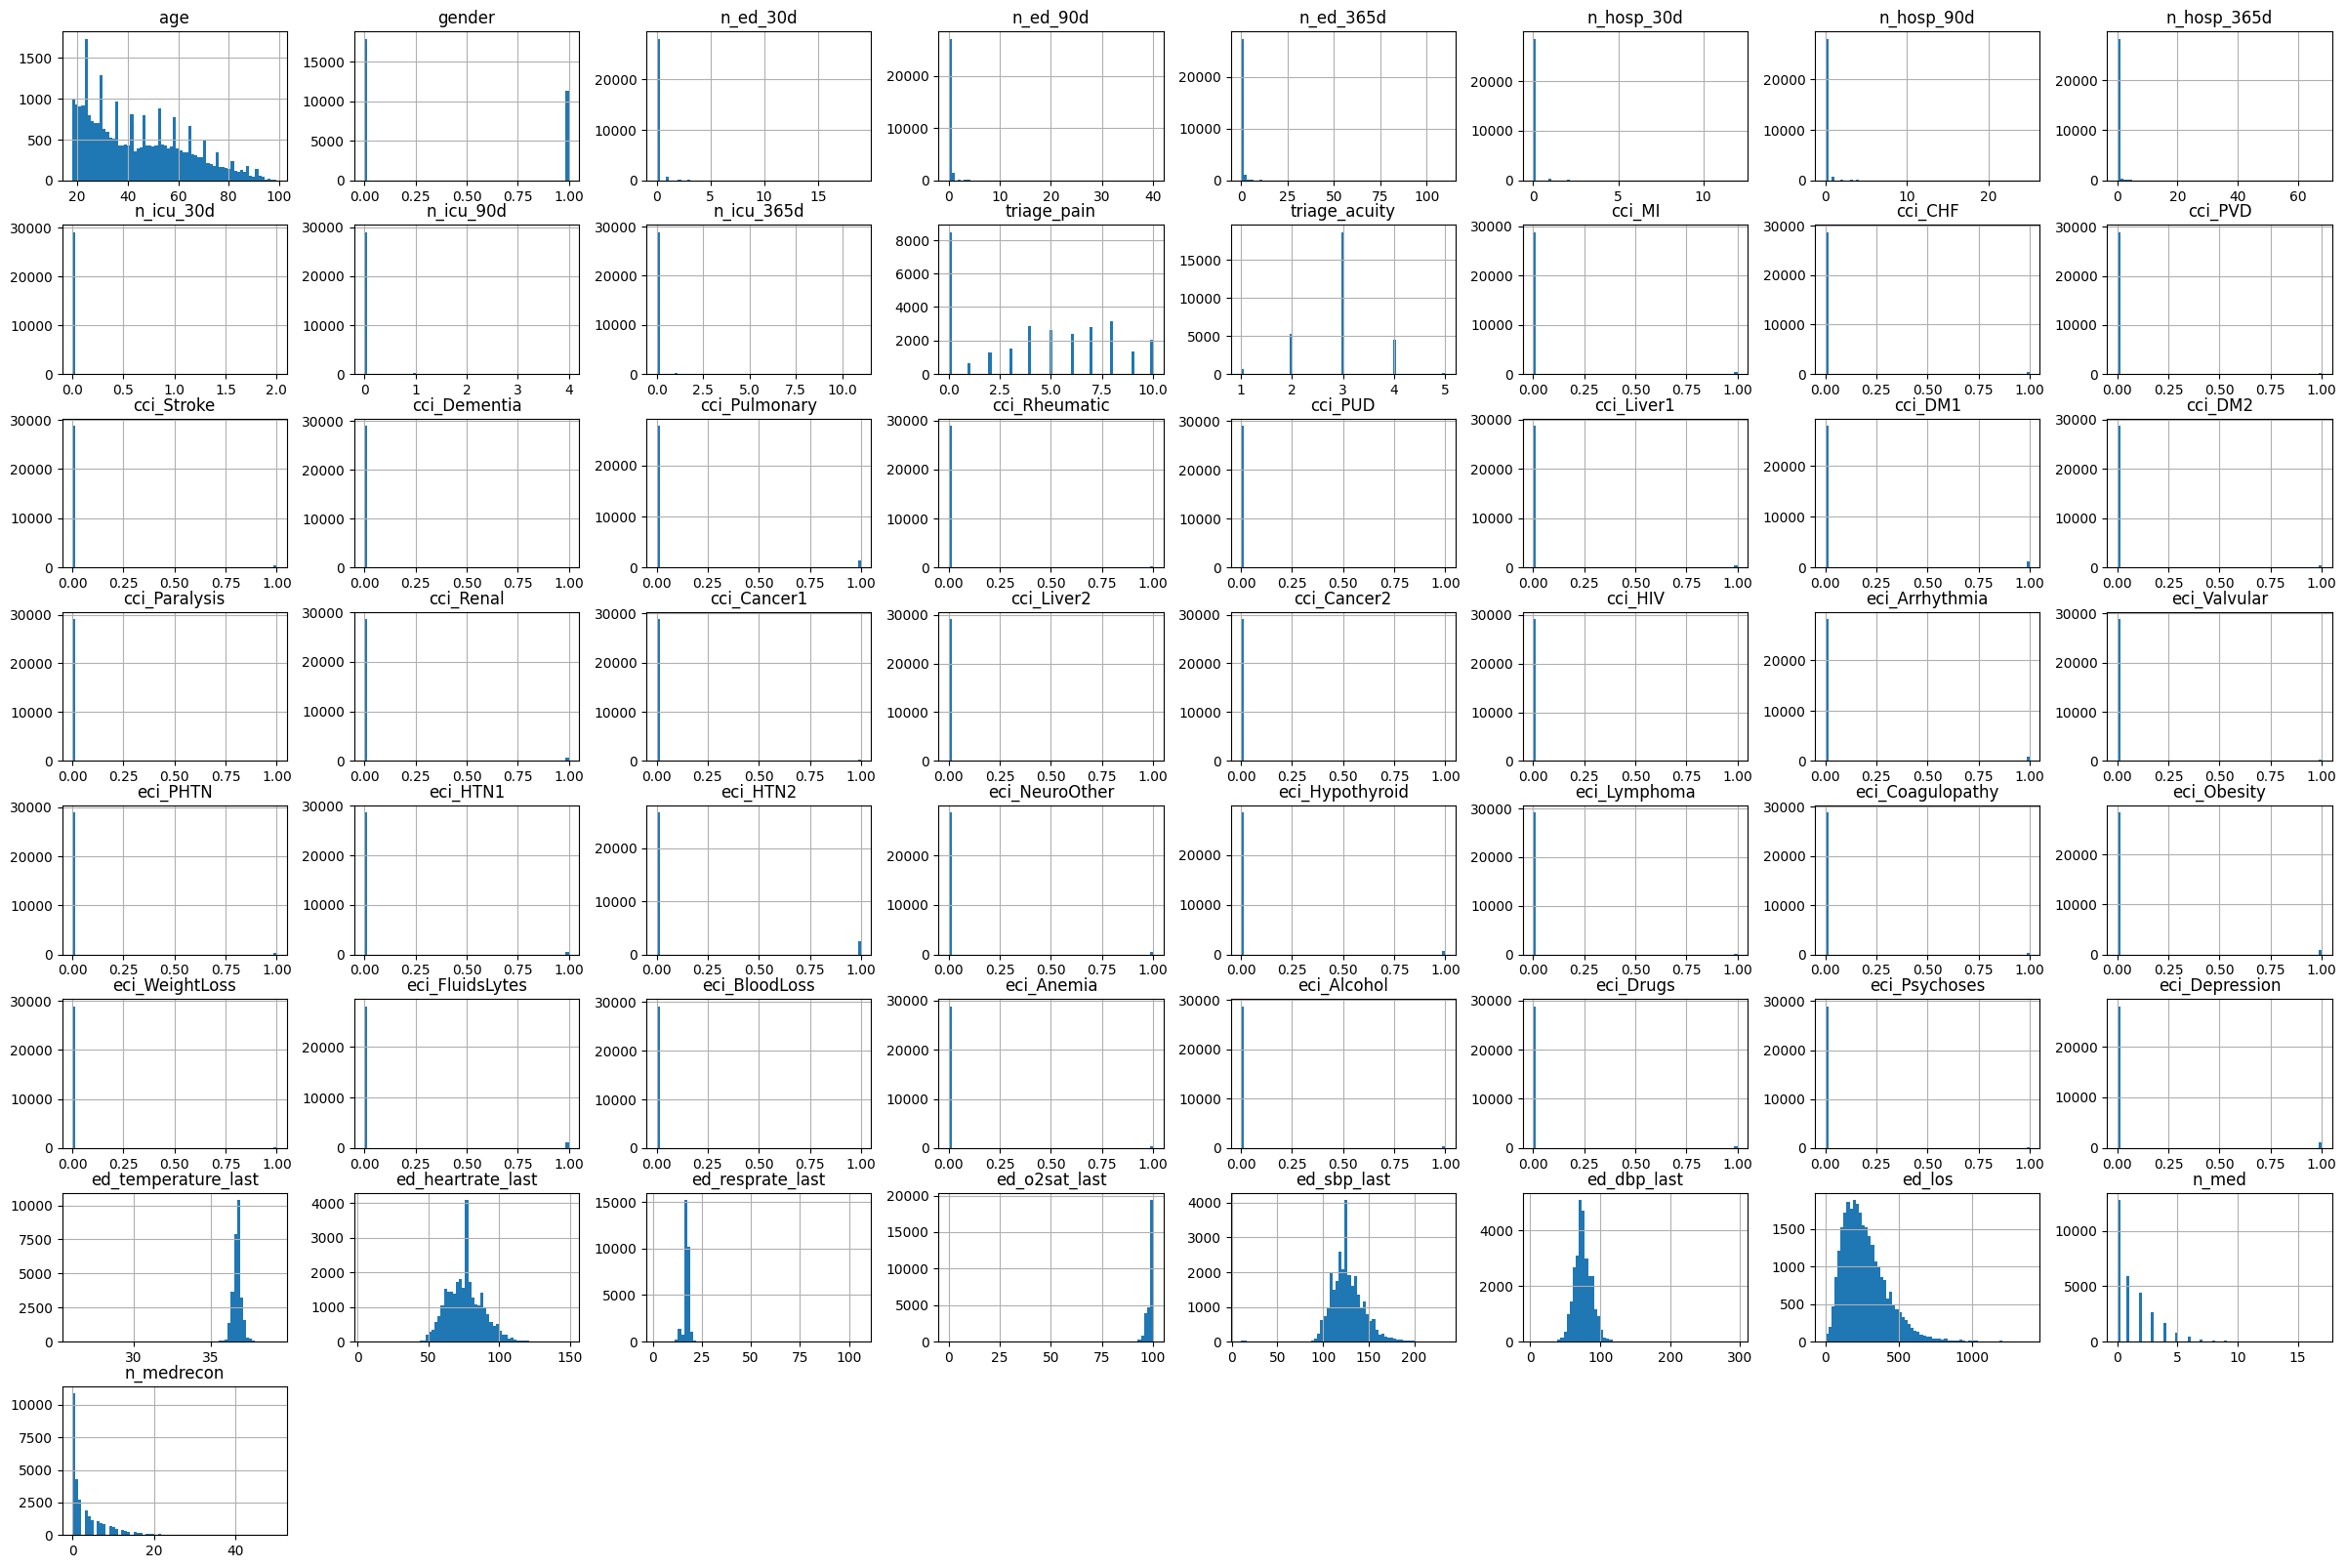

In [ ]:
os.mkdir(path + '/histogram')
misclassified_trainX = X_train[y_train!=train_new_probs]
classified_trainX = X_train[y_train ==train_new_probs]
misclassified_testX = X_test[y_test!=new_probs]
classified_testX = X_test[y_test ==new_probs]


ax = misclassified_trainX.hist(bins=67, figsize=(30,20))
fig = ax[0][0].get_figure()
ax1 = classified_trainX.hist(bins=67, figsize=(30,20))
fig1 = ax1[0][0].get_figure()

ax2 = misclassified_testX.hist(bins=67, figsize=(30,20))
fig2 = ax2[0][0].get_figure()
ax3 = classified_testX.hist(bins=67, figsize=(30,20))
fig3 = ax3[0][0].get_figure()
fig.savefig(path + '/histogram/misclassified_trainX.png')
fig1.savefig(path + '/histogram/classified_trainX.png')
fig2.savefig(path + '/histogram/misclassified_testX.png')
fig3.savefig(path + '/histogram/classified_testX.png')


Recording result to a csv file

In [ ]:
import csv
with open(path +'/paper_code_result.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    
    header = ['roc_auc', 'average_precision', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity']
    writer.writerow(header)
    
    result = [str(a) for a in result]
    print(result)
    writer.writerow(result)
    
    file.close()

['0.6981885240298187', '0.1701139391508219', '0.6208022388059702', '0.6638994250817052', '0.044106625', '0.6899266332583345', '0.7085886448650576', '0.005508753322884139', '0.160256667661256', '0.18458388677440932', '0.006782524814910631', '0.6096316070388471', '0.643933828435952', '0.0101164913018153', '0.6482866045831218', '0.6667451696323616', '0.006365192271826166', '0.6618024192633275']


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 3.0005381107330322 seconds
AUC: 0.6815494692500426
AUPRC: 0.16248729316318267
Sensitivity: 0.5988805970149254
Specificity: 0.6587227748753548
Score thresold: 0.04371526323940685
2.5 97.5


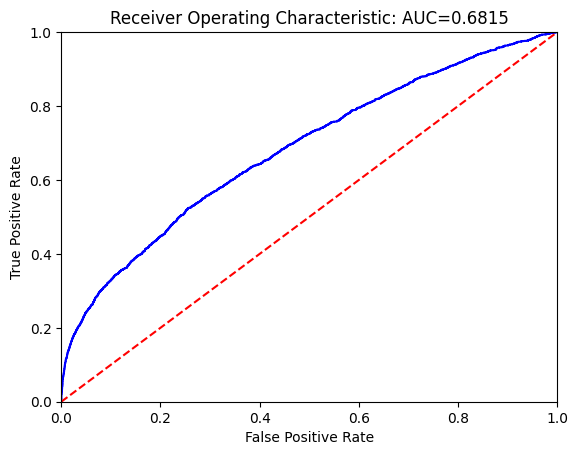

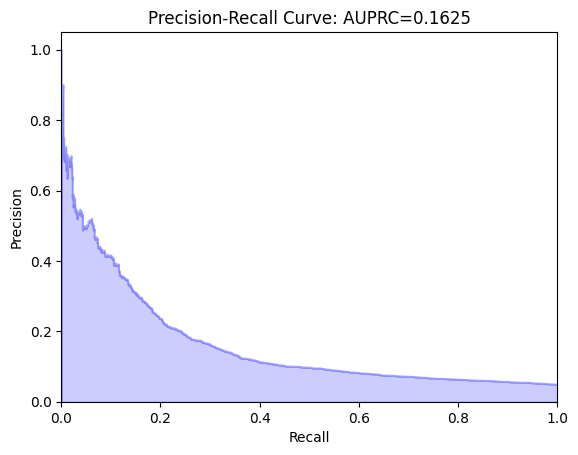

In [ ]:
from sklearn.feature_selection import SelectFromModel
lo=LogisticRegression(random_state=1)
start = time.time()
lo.fit(X_train,y_train)
# model = SelectFromModel(lo, prefit=True)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
import pickle
with open('task3_logreg.pickle', 'wb') as model_dump:
    pickle.dump(lo, model_dump)
probs = lo.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
results = ["Logistic regression"]
results.extend(result)
results.append(runtime)
result_list.append(results)

C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 0.7851788997650146 seconds
AUC: 0.6068993433231039
AUPRC: 0.07137773095181528
Sensitivity: 0.5750932835820896
Specificity: 0.5823373649180563
Score thresold: 0.04748030903464583
2.5 97.5


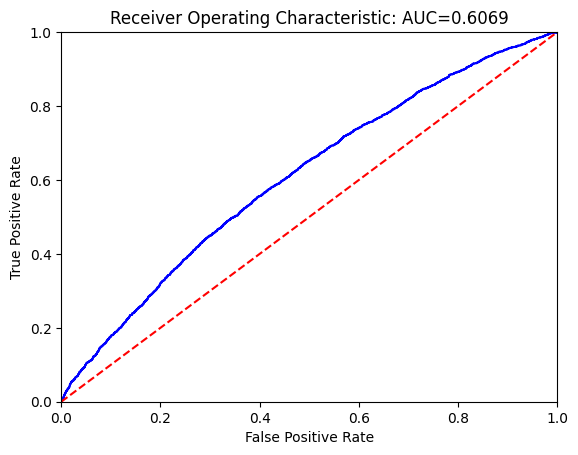

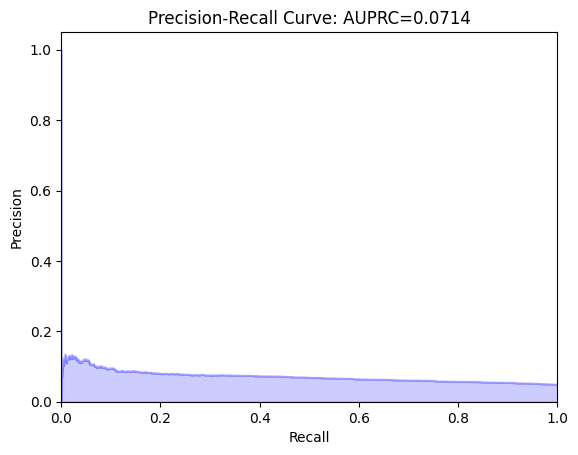

In [ ]:
from sklearn.feature_selection import SelectFromModel
lo=LogisticRegression(random_state=1)
start = time.time()
lo.fit(X_train[['ed_los','age','ed_sbp_last','ed_heartrate_last','ed_dbp_last',
'ed_temperature_last','n_medrecon','triage_pain','n_med','ed_o2sat_last',
'ed_resprate_last','n_ed_365d','n_ed_90d','n_ed_30d','n_hosp_365d','triage_acuity',
'gender','n_hosp_90d','n_hosp_30d','chiefcom_abdominal_pain','eci_HTN2','eci_Depression',
'cci_Pulmonary','chiefcom_back_pain','eci_Alcohol','cci_DM1','eci_Arrhythmia','eci_FluidsLytes',
'eci_Drugs']],y_train)
# model = SelectFromModel(lo, prefit=True)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
import pickle
with open('task3_logreg.pickle', 'wb') as model_dump:
    pickle.dump(lo, model_dump)
probs = lo.predict_proba(X_test[['ed_los','age','ed_sbp_last','ed_heartrate_last','ed_dbp_last',
'ed_temperature_last','n_medrecon','triage_pain','n_med','ed_o2sat_last',
'ed_resprate_last','n_ed_365d','n_ed_90d','n_ed_30d','n_hosp_365d','triage_acuity',
'gender','n_hosp_90d','n_hosp_30d','chiefcom_abdominal_pain','eci_HTN2','eci_Depression',
'cci_Pulmonary','chiefcom_back_pain','eci_Alcohol','cci_DM1','eci_Arrhythmia','eci_FluidsLytes',
'eci_Drugs']])
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
results = ["Logistic regression"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [ ]:
exp1.iloc[:,:10]

,ed_los,age,ed_sbp_last,ed_dbp_last,ed_heartrate_last,ed_temperature_last,n_medrecon,triage_pain,n_med,ed_o2sat_last
0,0.000,0.000,235.000,70.000,116.000,99.000,16.000,78.000,36.667,0
1,0.000,0.000,61.000,83.000,130.000,98.000,18.000,92.000,36.556,0
2,2.000,2.000,332.000,85.000,170.000,100.000,18.000,56.000,36.444,0
3,0.000,5.000,407.000,80.000,123.000,96.000,16.000,82.000,37.167,0
4,0.000,2.000,477.000,69.000,142.000,96.000,16.000,82.000,36.778,0
...,...,...,...,...,...,...,...,...,...,...
44058,3.000,3.000,286.000,74.000,122.000,99.000,18.000,67.000,36.722,0
44059,0.000,1.000,148.000,74.000,109.000,97.000,16.000,90.000,37.167,0
44060,0.000,0.000,126.000,73.000,126.000,99.000,17.000,77.000,36.722,0
44061,5.000,4.000,461.000,67.000,110.000,98.000,16.000,78.000,36.667,1


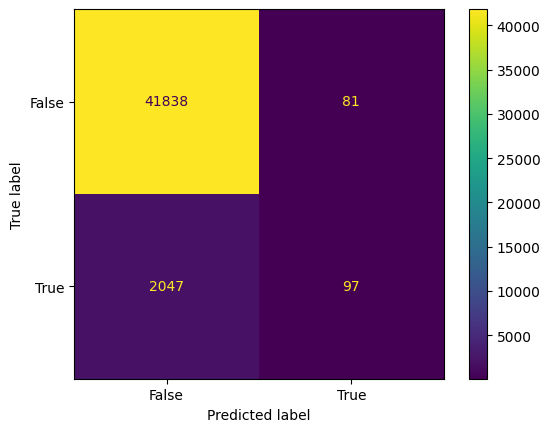

In [ ]:
train_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
train_cm_display.plot()

Text(0, 0.5, 'AUC')

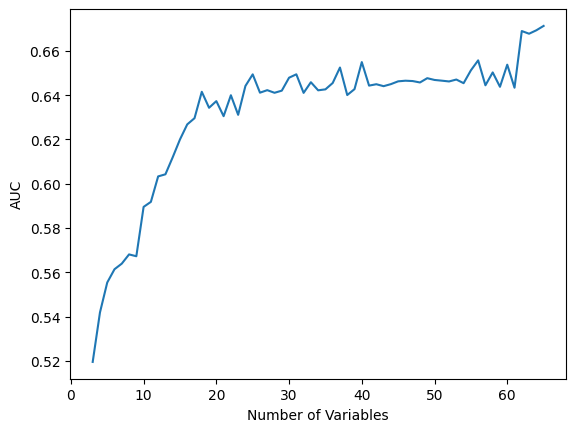

In [ ]:
# i = 10
# ind = []
# while i < 64:
#     ind.append([i])
#     i += 1


# g1 = pd.DataFrame({'Num_var':ind,'Auc':e_r})

# g1.plot()
plt.plot(range(3, len(e_r) + 3), e_r)
plt.xlabel("Number of Variables")
plt.ylabel("AUC")

#plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
# plt.show()

In [ ]:
e_r

[0.5227734533693801,
 0.522797308900285,
 0.5216312641241656,
 0.5215954808278083,
 0.5225760277105135,
 0.5229828067936991,
 0.5220857542691609,
 0.5223666742861944,
 0.5225521721796087,
 0.5221215375655182,
 0.5218883286102942,
 0.5220738265037085,
 0.5221215375655182,
 0.5232160157489231,
 0.522145393096423,
 0.5217028307168801,
 0.5217386140132373,
 0.5219002563757467,
 0.5216789751859752,
 0.521726686247785,
 0.5219002563757467,
 0.5223308909898371,
 0.5230424456209612,
 0.5227853811348325,
 0.522145393096423,
 0.522564099945061,
 0.5225283166487038,
 0.5232637268107327,
 0.5221215375655182,
 0.5223666742861944,
 0.5225163888832514,
 0.5225521721796087,
 0.5223786020516468,
 0.522797308900285,
 0.5206083525334753,
 0.5225521721796087,
 0.5218883286102942,
 0.5225760277105135,
 0.5218764008448419,
 0.5222050319236851,
 0.5227734533693801,
 0.5222050319236851,
 0.5221692486273278,
 0.5225283166487038,
 0.5221215375655182,
 0.5230543733864137,
 0.5220976820346134,
 0.5221811763927803

In [ ]:
from sklearn.svm import SVC
from catboost import CatBoostRegressor,CatBoostClassifier

cat_model = CatBoostClassifier()
# Fit model
start = time.time()
cat_model.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
import pickle
with open('task3_logreg.pickle', 'wb') as model_dump:
    pickle.dump(cat_model, model_dump)
probs = cat_model.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
results = ["CatBoost"]
results.extend(result)
results.append(runtime)
result_list.append(results)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=1]="F": Cannot convert 'b'F'' to float

Learning rate set to 0.093755
0:	learn: 0.5707964	total: 20.3ms	remaining: 20.3s
1:	learn: 0.4776489	total: 50.7ms	remaining: 25.3s
2:	learn: 0.4078088	total: 84.3ms	remaining: 28s
3:	learn: 0.3551625	total: 113ms	remaining: 28.2s
4:	learn: 0.3149854	total: 143ms	remaining: 28.5s
5:	learn: 0.2845374	total: 175ms	remaining: 28.9s
6:	learn: 0.2612875	total: 195ms	remaining: 27.7s
7:	learn: 0.2429552	total: 223ms	remaining: 27.7s
8:	learn: 0.2292164	total: 244ms	remaining: 26.9s
9:	learn: 0.2191960	total: 269ms	remaining: 26.6s
10:	learn: 0.2107359	total: 297ms	remaining: 26.7s
11:	learn: 0.2039785	total: 331ms	remaining: 27.3s
12:	learn: 0.1986061	total: 364ms	remaining: 27.6s
13:	learn: 0.1946473	total: 393ms	remaining: 27.7s
14:	learn: 0.1910338	total: 413ms	remaining: 27.1s
15:	learn: 0.1882620	total: 440ms	remaining: 27s
16:	learn: 0.1861776	total: 468ms	remaining: 27s
17:	learn: 0.1842981	total: 500ms	remaining: 27.3s
18:	learn: 0.1827644	total: 532ms	remaining: 27.5s
19:	learn: 0.1

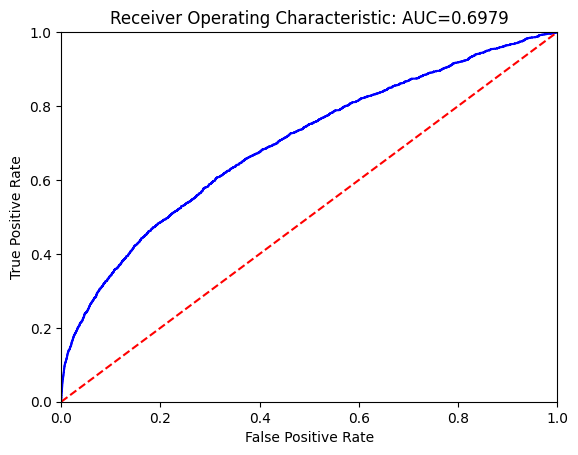

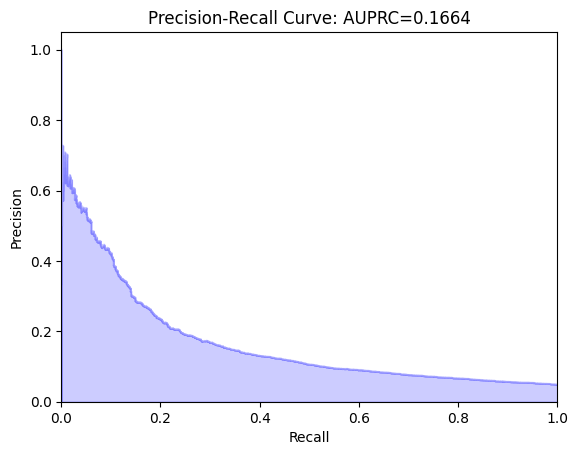

In [ ]:
from sklearn.svm import SVC
from catboost import CatBoostRegressor,CatBoostClassifier

cat_model = CatBoostClassifier()
# Fit model
start = time.time()
cat_model.fit(X_train[['ed_los','age','ed_sbp_last','ed_heartrate_last','ed_dbp_last',
'ed_temperature_last','n_medrecon','triage_pain','n_med','ed_o2sat_last',
'ed_resprate_last','n_ed_365d','n_ed_90d','n_ed_30d','n_hosp_365d','triage_acuity',
'gender','n_hosp_90d','n_hosp_30d','chiefcom_abdominal_pain','eci_HTN2','eci_Depression',
'cci_Pulmonary','chiefcom_back_pain','eci_Alcohol','cci_DM1','eci_Arrhythmia','eci_FluidsLytes',
'eci_Drugs','eci_Obesity','n_icu_365d','eci_NeuroOther','chiefcom_nausea_vomiting','cci_Liver1',
'eci_Hypothyroid','eci_Anemia']],y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
import pickle
with open('task3_logreg.pickle', 'wb') as model_dump:
    pickle.dump(cat_model, model_dump)
probs = cat_model.predict_proba(X_test[['ed_los','age','ed_sbp_last','ed_heartrate_last','ed_dbp_last',
'ed_temperature_last','n_medrecon','triage_pain','n_med','ed_o2sat_last',
'ed_resprate_last','n_ed_365d','n_ed_90d','n_ed_30d','n_hosp_365d','triage_acuity',
'gender','n_hosp_90d','n_hosp_30d','chiefcom_abdominal_pain','eci_HTN2','eci_Depression',
'cci_Pulmonary','chiefcom_back_pain','eci_Alcohol','cci_DM1','eci_Arrhythmia','eci_FluidsLytes',
'eci_Drugs','eci_Obesity','n_icu_365d','eci_NeuroOther','chiefcom_nausea_vomiting','cci_Liver1',
'eci_Hypothyroid','eci_Anemia']])
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
results = ["CatBoost"]
results.extend(result)
results.append(runtime)
result_list.append(results)

Training time: 0.3340747356414795 seconds
AUC: 0.6743452491265137
AUPRC: 0.1031415670627997
Sensitivity: 0.6319962686567164
Specificity: 0.6212695913547557
Score thresold: 6.900778089868455e-11
2.5 97.5


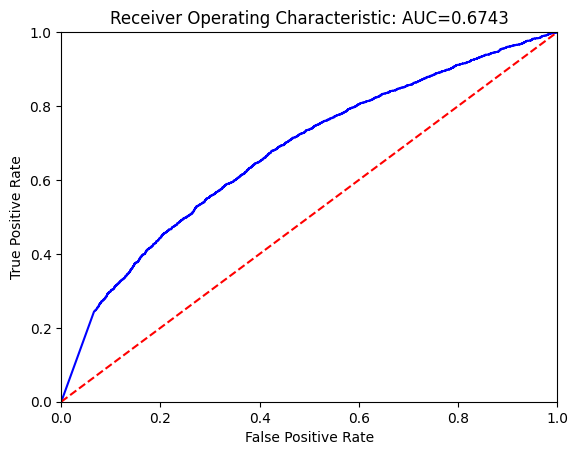

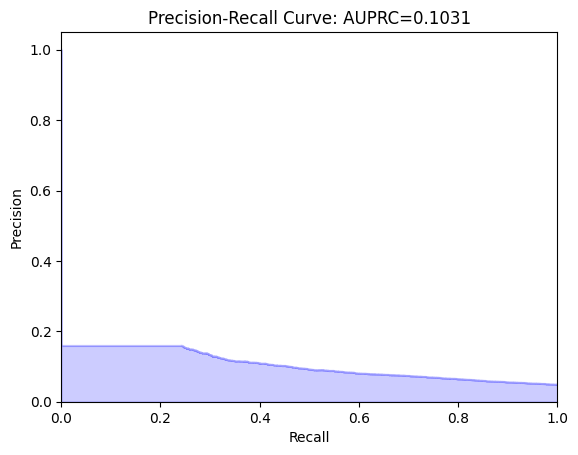

In [ ]:
NB_model = GaussianNB()
# Fit model
start = time.time()
NB_model.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
import pickle
with open('task3_logreg.pickle', 'wb') as model_dump:
    pickle.dump(cat_model, model_dump)
probs = NB_model.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
results = ["GaussianNB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

Learning rate set to 0.093755
0:	learn: 0.5713006	total: 47.9ms	remaining: 47.8s
1:	learn: 0.4790345	total: 96.1ms	remaining: 48s
2:	learn: 0.4075847	total: 127ms	remaining: 42.2s
3:	learn: 0.3545911	total: 157ms	remaining: 39.2s
4:	learn: 0.3143446	total: 222ms	remaining: 44.1s
5:	learn: 0.2834878	total: 268ms	remaining: 44.4s
6:	learn: 0.2610699	total: 315ms	remaining: 44.7s
7:	learn: 0.2436252	total: 335ms	remaining: 41.6s
8:	learn: 0.2300252	total: 380ms	remaining: 41.9s
9:	learn: 0.2190528	total: 426ms	remaining: 42.2s
10:	learn: 0.2103900	total: 458ms	remaining: 41.2s
11:	learn: 0.2041722	total: 489ms	remaining: 40.3s
12:	learn: 0.1987157	total: 522ms	remaining: 39.6s
13:	learn: 0.1942558	total: 555ms	remaining: 39.1s
14:	learn: 0.1908289	total: 600ms	remaining: 39.4s
15:	learn: 0.1880402	total: 647ms	remaining: 39.8s
16:	learn: 0.1859367	total: 678ms	remaining: 39.2s
17:	learn: 0.1842473	total: 698ms	remaining: 38.1s
18:	learn: 0.1827227	total: 759ms	remaining: 39.2s
19:	learn: 

C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.6988092240258665
AUPRC: 0.16837375573621077
Sensitivity: 0.6068097014925373
Specificity: 0.6926214842911329
Score thresold: 0.031816398810585254
2.5 97.5


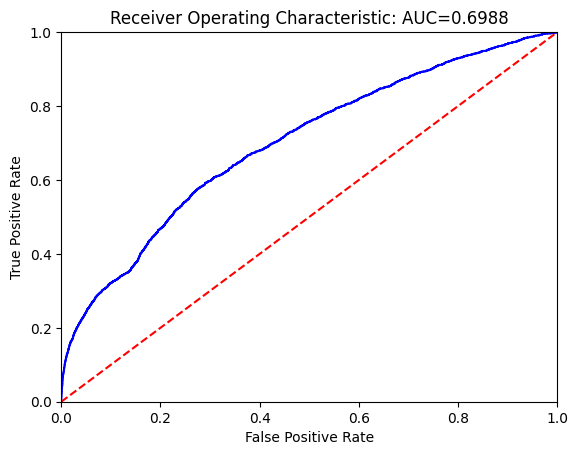

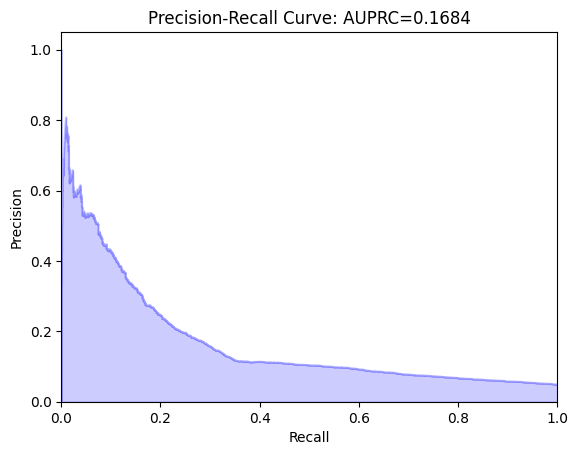

In [ ]:

# class LSTM_MLP(tf.keras.Model):
#     def __init__(self):
#         super(LSTM_MLP, self).__init__()
#         self.dense_1 = Dense(96, activation='relu')
#         self.lstm = LSTM(32)
#         self.dense_2 = Dense(64, activation='relu')
#         self.classifier = Dense(1, activation='sigmoid')
        
#     def call(self, x):
#         x1, x2 = x
#         x = self.dense_1(x1)
#         lstm_output = self.lstm(x2)
#         x = concatenate([x, lstm_output])
#         x = self.dense_2(x)
#         return self.classifier(x)
    
# clp = LSTM_MLP()
# lstm.compile(loss='binary_crossentropy', 
#               optimizer=optimizers.Adam(learning_rate=0.001))
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostRegressor,CatBoostClassifier
X, y = X_train,y_train


#clp._estimator_type = "classifier"
clf1 = GaussianNB()
clf2 = CatBoostClassifier()
clf3 = LogisticRegression(random_state=1)
eclf = VotingClassifier(estimators=[('NB', clf1), ('CB', clf2), ('LR', clf3)],voting='soft')

# for clf, label in zip([clf1, clf2, clf3, eclf], ['NB', 'CB', 'LR', 'Ensemble']):
#        scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
#        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
start = time.time()
eclf.fit(X_train,y_train)
runtime = time.time() - start
probs = eclf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
results = ["Ensemble Classfier"]
results.extend(result)
results.append(runtime)
result_list.append(results)



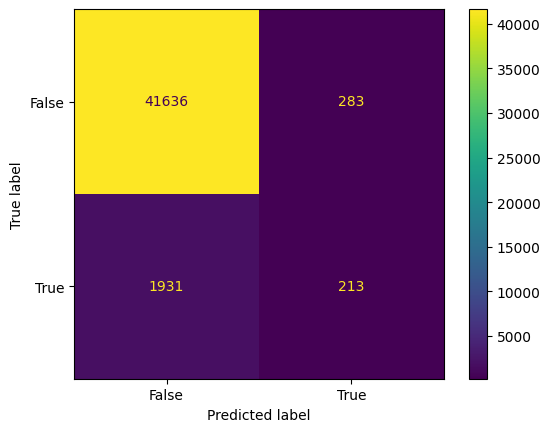

0.6618024192633275


In [ ]:
probs_em = eclf.predict(X_test)
cm1 = metrics.confusion_matrix(y_test,probs_em)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = [False, True])

cm_display.plot()
plt.savefig(path + '/confusion_matrix.png')
plt.show()
acc = metrics.accuracy_score(y_test, new_probs)
print(acc)

In [ ]:

result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task3.csv'), index=False)
formatted_result_df

ValueError: 19 columns passed, passed data had 20 columns

In [ ]:

print(imblearn.__version__)

0.11.0


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 5.2821996212005615 seconds
AUC: 0.6041200237629573
AUPRC: 0.11304231894006632
Sensitivity: 0.5289179104477612
Specificity: 0.635702187552184
Score thresold: 0.46163319305453965
2.5 97.5


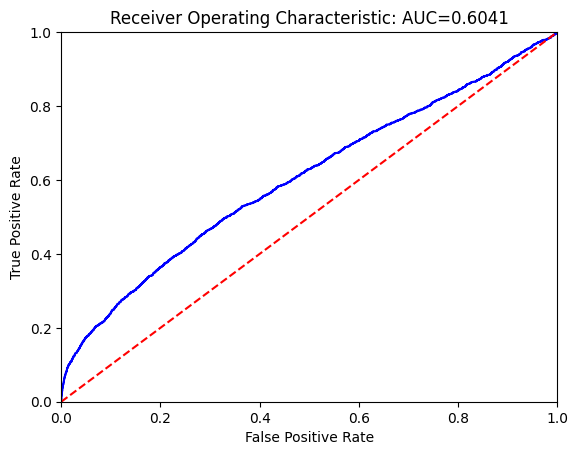

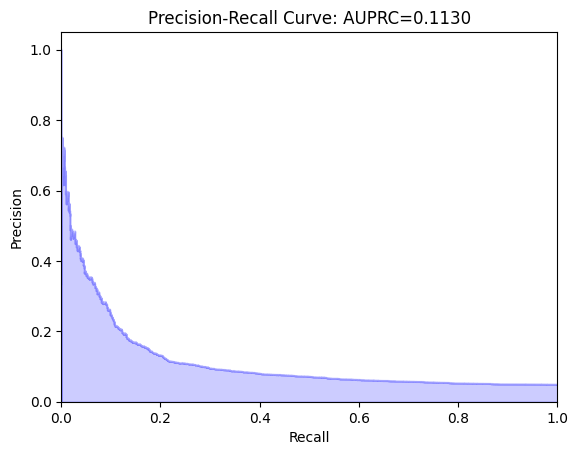

In [ ]:
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
oversample = SMOTE()
X, y = oversample.fit_resample(X_train, y_train)
lo=LogisticRegression(random_state=1)
start = time.time()
lo.fit(X,y)
# model = SelectFromModel(lo, prefit=True)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
import pickle
with open('task3_logreg.pickle', 'wb') as model_dump:
    pickle.dump(lo, model_dump)
probs = lo.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
results = ["Logistic regression"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [ ]:
len(probs_em)

44063

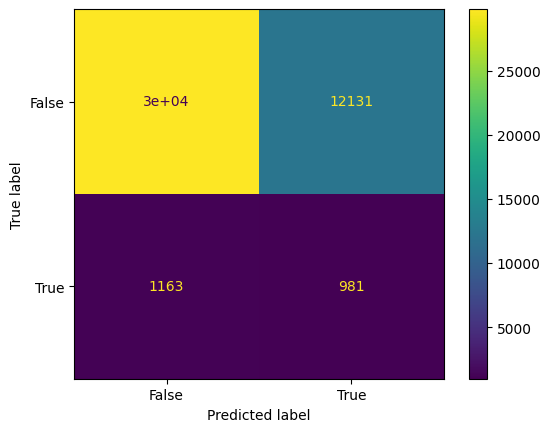

0.698295622177337


In [ ]:
probs_em = lo.predict(X_test)
cm1 = metrics.confusion_matrix(y_test,probs_em)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = [False, True])

cm_display.plot()
plt.savefig(path + '/confusion_matrix.png')
plt.show()
acc = metrics.accuracy_score(y_test, probs_em)
print(acc)

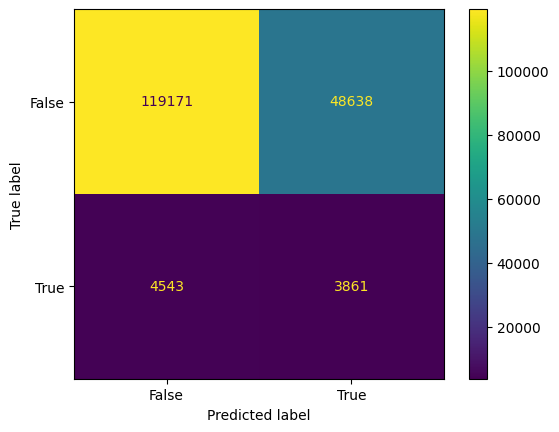

0.6982004732908469


In [ ]:
probs_em = lo.predict(X_train)
cm1 = metrics.confusion_matrix(y_train,probs_em)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = [False, True])

cm_display.plot()
plt.savefig(path + '/confusion_matrix.png')
plt.show()
acc = metrics.accuracy_score(y_train, probs_em)
print(acc)